In [1]:
# The set contains the following mutations:

# • 学习率 ALTER-LEARNING-RATE (sampling details below).
# • 线性 IDENTITY (effectively means “keep training”).
# • 权重 RESET-WEIGHTS (sampled as in He et al. (2015), for
#       example).
# • 增 INSERT-CONVOLUTION (inserts a convolution at a random location in the “convolutional
#       backbone”, as in Figure 1. The inserted convolution has 3 × 3 filters, strides
#       of 1 or 2 at random, number of channels same as input.May apply batch-normalization
#       and ReLU activation or none at random).
# • 删 REMOVE-CONVOLUTION.
# • 步长 ALTER-STRIDE (only powers of 2 are allowed).
# • 通道数 ALTER-NUMBER-OF-CHANNELS (of random conv.).
# • 滤波器大小 FILTER-SIZE (horizontal or vertical at random, on random convolution, odd values only).
# • INSERT-ONE-TO-ONE (inserts a one-to-one/identity
#       connection, analogous to insert-convolution mutation).
# • 增跳层 ADD-SKIP (identity between random layers).
# • 删跳层 REMOVE-SKIP (removes random skip).

# 主要的组合实际为: conv+bn+relu

#########################################################################################################

# OUR--MLP

# 学习率α
# 增layer
# 增skip
# 设置'linear'/'relu'

# 1.每次挑选两个个体, 确保个体已经被训练过了
# 2.挑选个体的fitness，(population过大->kill不好的)，反之(population过小->reproduce好的)

import os

import torch
import matplotlib.pyplot as plt
import torch.nn.functional as F
import random
import copy
import torchvision
import torch.utils.data as Data
import numpy as np

DNA_cnt = 0
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

class DNA(object):
    '''
    learning_rate, vertices[vertex_id]+type, edges[edge_id]
    '''
    # __dna_cnt = 0
    input_size = 28 * 28
    hidden_size = 128
    output_size = 10

    def __init__(self, learning_rate=0.05):
        '''
        注意，vertice 和 edges 中应该存引用
        '''
        global DNA_cnt
        self.dna_cnt = DNA_cnt
        DNA_cnt += 1
        self.fitness = -1.0
        self.learning_rate = learning_rate

        # layer
        l0 = Vertex(edges_in=set(),
                    edges_out=set(),
                    inputs_mutable=self.input_size,
                    outputs_mutable=self.input_size)
        l1 = Vertex(edges_in=set(),
                    edges_out=set(),
                    inputs_mutable=self.hidden_size,
                    outputs_mutable=self.hidden_size)
        l2 = Vertex(edges_in=set(),
                    edges_out=set(),
                    inputs_mutable=self.output_size,
                    outputs_mutable=self.output_size)
        self.vertices = []
        self.vertices.append(l0)
        self.vertices.append(l1)
        self.vertices.append(l2)

        # edge
        edg1 = Edge(from_vertex=l0, to_vertex=l1)
        edg2 = Edge(from_vertex=l1, to_vertex=l2)
        self.edges = []
        self.edges.append(edg1)
        self.edges.append(edg2)

        l0.edges_out.add(edg1)
        l1.edges_in.add(edg1), l1.edges_out.add(edg2)
        l2.edges_in.add(edg2)

    def __del__(self):
        class_name = self.__class__.__name__
        print(class_name, "[", self.dna_cnt, "]销毁->fitness", self.fitness, end='\n')

    def add_edge(self, from_vertex_id, to_vertex_id):
        """
        Adds an edge to the DNA graph, ensuring internal consistency.
        """
        edge = Edge(from_vertex=self.vertices[from_vertex_id],
                    to_vertex=self.vertices[to_vertex_id])
        self.edges.append(edge)
        self.vertices[from_vertex_id].edges_out.add(edge)
        self.vertices[to_vertex_id].edges_in.add(edge)
        return edge

    def calculate_flow(self):
        '''
        按顺序计算神经网络每层的输入输出size, outputs_mutable 默认不需要处理，即size
        '''
        for vertex_id, vertex in enumerate(self.vertices):
            # 先默认将input_mutable 置为0，然后处理inputs_mutable
            vertex.layer_size2zero()
            if len(vertex.edges_in) == 0:
                vertex.inputs_mutable = self.input_size
                print("[calculate_flow]->start Node 0:", vertex.inputs_mutable)
            else:
                print("Node", vertex_id, 'size:', vertex.outputs_mutable, end=': ')
                for edg in vertex.edges_in:
                    vertex.inputs_mutable += edg.from_vertex.outputs_mutable
                    print("[",
                          self.vertices.index(edg.from_vertex),
                          ',',
                          self.vertices.index(edg.to_vertex),
                          "]",
                          end=' ')
                print()
        # outputs_mutable 默认不需要处理，即size

    def mutate_layer_size(self, v_list=[], s_list=[]):
        for i in range(len(v_list)):
            self.vertices[v_list[i]].outputs_mutable = s_list[i]

    def add_vertex(self, after_vertex_id, vertex_size, vertex_type):
        '''
        3.0: 所有 vertex 和 edg 中记录的都是引用
        '''
        # 先寻找那条应该被移除的边
        for i in self.vertices[after_vertex_id - 1].edges_out:
            if i.to_vertex == self.vertices[after_vertex_id]:
                self.vertices[after_vertex_id - 1].edges_out.remove(i)
                break
        for i in self.vertices[after_vertex_id].edges_in:
            if i.from_vertex == self.vertices[after_vertex_id - 1]:
                self.vertices[after_vertex_id].edges_in.remove(i)
                break
        for i, edge in enumerate(self.edges):
            if edge.from_vertex == self.vertices[
                    after_vertex_id - 1] and edge.to_vertex == self.vertices[after_vertex_id]:
                del self.edges[i]

        # 创建新的 vertex, 并加入队列
        vertex_add = Vertex(edges_in=set(),
                            edges_out=set(),
                            inputs_mutable=self.vertices[after_vertex_id - 1].outputs_mutable,
                            outputs_mutable=vertex_size,
                            type=vertex_type)
        self.vertices.insert(after_vertex_id, vertex_add)

        # 创建新的 edge, 并加入队列
        edge_add1 = Edge(from_vertex=self.vertices[after_vertex_id - 1],
                         to_vertex=self.vertices[after_vertex_id])
        edge_add2 = Edge(from_vertex=self.vertices[after_vertex_id],
                         to_vertex=self.vertices[after_vertex_id + 1])
        self.edges.append(edge_add1)
        self.edges.append(edge_add2)

        self.vertices[after_vertex_id - 1].edges_out.add(edge_add1)
        vertex_add.edges_in.add(edge_add1), vertex_add.edges_out.add(edge_add2)
        self.vertices[after_vertex_id + 1].edges_in.add(edge_add2)

    def has_edge(self, from_vertex_id, to_vertex_id):
        vertex_before = self.vertices[from_vertex_id]
        vertex_after = self.vertices[to_vertex_id]
        for edg in self.edges:
            if edg.from_vertex == vertex_before and edg.to_vertex == vertex_after:
                return True
        return False


class Vertex(object):
    '''
    edges_in, edges_out, HasField(bn_relu/linear), 
    inputs_mutable, outputs_mutable, properties_mutable
    '''
    def __init__(self, edges_in, edges_out, inputs_mutable, outputs_mutable, type='linear'):
        '''
        edges_in / edges_out : 使用set
        '''
        self.edges_in = edges_in
        self.edges_out = edges_out
        self.type = type
        self.inputs_mutable = inputs_mutable
        self.outputs_mutable = outputs_mutable

    def layer_size2zero(self):
        '''
        为方便神经网络计算，将 inputs_mutable 的size置为 0
        '''
        self.inputs_mutable = 0
        # self.outputs_mutable = 0


class Edge(object):
    '''
    No Need:type, depth_factor, filter_half_width, filter_half_height, 
            stride_scale, depth_precedence, scale_precedence
    '''
    def __init__(self, from_vertex, to_vertex):
        self.from_vertex = from_vertex  # Source vertex ID.
        self.to_vertex = to_vertex  # Destination vertex ID.
        self.state = 1


class Model(torch.nn.Module):
    def __init__(self, DNA):
        super(Model, self).__init__()
        self.dna = DNA
        self.layer = torch.nn.ModuleList()
        for vertex in DNA.vertices[1:]:
            # 默认第一层和最后一层非hidden层
            self.layer.append(torch.nn.Linear(vertex.inputs_mutable, vertex.outputs_mutable))
        self.batch_size = Evolution_pop.BATCH_SIZE

    def forward(self, input):
        '''
        配置每层的 输入、输出、激活函数
        '''
        # self.x = [ input, ]
        # x = np.array()
        # x = torch.stack(input, )
        block_h = input.shape[0]
        x = {
            0: input,
        }
        for index, layer in enumerate(self.layer, start=1):
            length = len(x)
            # a = x[length - 1]
            a = torch.empty(block_h, 0)
            for edg in self.dna.vertices[index].edges_in:
                # a += x[self.dna.edges[i].from_vertex]
                a = torch.cat((a, x[self.dna.vertices.index(edg.from_vertex)]), dim=1)
            # a -= x[length - 1]
            if self.dna.vertices[index].type == 'bn_relu':
                x[index] = F.relu(layer(a))
            elif self.dna.vertices[index].type == 'linear':
                x[index] = layer(a)
        return x[len(x) - 1]


class StructMutation():
    '''
    can mutate: hidden size, add edge, learning rate, add vertex, 
    '''
    def __init__(self):
        self._edge_types = []

    def mutate(self, dna):
        '''
        TODO: 可能出现由于概率'没有任何变异'的情况，不能让其发生
        '''
        # mutated_dna = copy.deepcopy(dna)
        mutated_dna = dna
        cnt = 0
        # 应该要保证发生变异
        while cnt == 0:
            # 1. Try the candidates in random order until one has the right connectivity.(Add)
            for from_vertex_id, to_vertex_id in self._vertex_pair_candidates(dna):
                if random.random() > 0.7:
                    self._mutate_structure(mutated_dna, from_vertex_id, to_vertex_id)
                    cnt += 1

            # 2. Try to mutate learning Rate
            if random.random() > 0.5:
                self.mutate_learningRate(mutated_dna)
                cnt += 1

            # 3. mutate the hidden layer's size
            # self.mutate_hidden_size(dna)

            # 4. Mutate the vertex (Add)
            if random.random() > 0.5:
                self.mutate_vertex(mutated_dna)
                cnt += 1

        return mutated_dna

    def _vertex_pair_candidates(self, dna):
        """Yields connectable vertex pairs."""
        from_vertex_ids = self._find_allowed_vertices(dna)
        # if not from_vertex_ids: raise exceptions.MutationException(), 打乱次序
        random.shuffle(from_vertex_ids)

        to_vertex_ids = self._find_allowed_vertices(dna)
        # if not to_vertex_ids: raise exceptions.MutationException()
        random.shuffle(to_vertex_ids)

        for to_vertex_id in to_vertex_ids:
            # Avoid back-connections. TODO: 此处可能会涉及到 拓扑图的顺序判断
            # disallowed_from_vertex_ids, _ = topology.propagated_set(to_vertex_id)
            disallowed_from_vertex_ids = self._find_disallowed_from_vertices(dna, to_vertex_id)
            for from_vertex_id in from_vertex_ids:
                if from_vertex_id in disallowed_from_vertex_ids:
                    continue
                # This pair does not generate a cycle, so we yield it.
                yield from_vertex_id, to_vertex_id

    def _find_allowed_vertices(self, dna):
        ''' TODO: 除第一层(假节点)外的所有vertex_id '''
        return list(range(0, len(dna.vertices)))

    def _find_disallowed_from_vertices(self, dna, to_vertex_id):
        ''' 寻找不可作为起始层索引的：反向链接的，重复连接的Edge '''
        res = list(range(to_vertex_id, len(dna.vertices)))
        # 排查每个 vertex 是否不符合, 即索引在前面的 vertex 的所有 edges_out
        for i, vertex in enumerate(dna.vertices[:to_vertex_id]):
            for edge in vertex.edges_out:
                if dna.vertices.index(edge.to_vertex) == to_vertex_id:
                    if i not in res:
                        res.append(i)
                        continue
        return res

    def _mutate_structure(self, dna, from_vertex_id, to_vertex_id):
        """Adds the edge to the DNA instance."""
        # edge_id = _random_id()
        # edge_id = len(dna.edges) + 1
        # edge_type = random.choice(self._edge_types)
        if dna.has_edge(from_vertex_id, to_vertex_id):
            return False
        else:
            print("[_mutate_structure]->prepare to :add_edge")
            # new_edge = dna.add_edge(from_vertex_id, to_vertex_id, edge_type)
            new_edge = dna.add_edge(from_vertex_id, to_vertex_id)
            # TODO: ...
            return True

    def mutate_hidden_size(self, dna):
        '''
        TODO: mutate the hidden layer's size 
        高斯分布随机生成, 对所有 hidden layer 变动...不可取
        '''

        for i in list(range(1, len(dna.vertices) - 1)):
            if random.random() > 0.6:
                last = dna.vertices[i].outputs_mutable
                before = dna.vertices[i - 1].outputs_mutable
                after = dna.vertices[i + 1].outputs_mutable

                alpha = min(before - last, last - after) / 3
                next = last + alpha * np.random.randn(1)
                next = int(next[0])
                if next > before:
                    next = before
                elif next < after:
                    next = after
                dna.vertices[i].outputs_mutable = next

    def mutate_learningRate(self, dna):
        # mutated_dna = copy.deepcopy(dna)
        mutated_dna = dna
        # Mutate the learning rate by a random factor between 0.5 and 2.0,
        # uniformly distributed in log scale.
        factor = 2**random.uniform(-1.0, 1.0)
        mutated_dna.learning_rate = dna.learning_rate * factor
        return mutated_dna

    def mutate_vertex(self, dna):
        # mutated_dna = copy.deepcopy(dna)
        mutated_dna = dna
        # 随机选择一个 vertex_id 插入 vertex, TODO: size 默认在前后两层之间??
        after_vertex_id = random.choice(self._find_allowed_vertices(dna))
        if after_vertex_id == 0:
            return mutated_dna

        print('outputs_mutable', dna.vertices[after_vertex_id].outputs_mutable,
              dna.vertices[after_vertex_id - 1].outputs_mutable)
        vertex_size = random.randint(dna.vertices[after_vertex_id].outputs_mutable,
                                     dna.vertices[after_vertex_id - 1].outputs_mutable)
        # TODO: how it supposed to mutate
        vertex_type = 'linear'
        if random.random() > 0.5:
            vertex_type = 'bn_relu'
        mutated_dna.add_vertex(after_vertex_id, vertex_size, vertex_type)
        return mutated_dna


class Evolution_pop:
    _population_size_setpoint = 5
    _max_layer_size = 4
    _evolve_time = 50
    fitness_pool = []

    EPOCH = 1  # 训练整批数据多少次
    BATCH_SIZE = 50

    # LR = 0.001          # 学习率

    def __init__(self, data):
        '''
        初始化DNA: 一层hidden(节点数不同); 都为linear
        接收传入的训练数据 data
        初始化 Mutation 类
        '''
        self.population = []
        for i in range(self._population_size_setpoint):
            dna_iter = DNA()
            dna_iter.mutate_layer_size(
                v_list=[1], s_list=[random.randint(dna_iter.output_size, dna_iter.input_size)])
            self.population.append(dna_iter)
        self.data = data
        self.struct_mutation = StructMutation()

        self.fitness_dir = {}

    def decode(self):
        ''' 对当前population队列中的每个未训练过的个体进行训练 '''
        for dna in self.population:
            if dna.fitness != -1.0:
                continue
            # TODO: 新训练的个体将fitness加入fitness_pool
            dna.calculate_flow()
            net = Model(dna)
            print("[decode].[", dna.dna_cnt, "]", net)
            optimizer = torch.optim.Adam(net.parameters(), lr=dna.learning_rate)
            # the target label is not one-hotted
            loss_func = torch.nn.CrossEntropyLoss()

            train_loader, test_x, test_y = self.data.getData()
            test_x = test_x.view(-1, 784)
            # print("[Evolution_pop].[decode]->test_x: ", test_x.shape)
            accuracy = 0
            # training and testing
            for epoch in range(self.EPOCH):
                step = 0
                # TODO: 用movan的enumerate会报错，why?
                max_tep = int(60000 / train_loader.batch_size)
                for step, (b_x, b_y) in enumerate(train_loader):
                    b_x = b_x.view(-1, 784)
                    # print("[b_x, b_y].shape: ", b_x.shape, b_y.shape)
                    # 分配 batch data, normalize x when iterate train_loader
                    output = net(b_x)  # cnn output
                    loss = loss_func(output, b_y)  # cross entropy loss
                    # clear gradients for this training step
                    optimizer.zero_grad()
                    loss.backward()  # backpropagation, compute gradients
                    optimizer.step()  # apply gradients
                    if step % 100 == 0:
                        test_output = net(test_x)
                        pred_y = torch.max(test_output, 1)[1].data.numpy()
                        accuracy = float(
                            (pred_y == test_y.data.numpy()).astype(int).sum()) / float(
                                test_y.size(0))
                        # print('Epoch: ', epoch, 'step: ', step,'| train loss: %.4f' % loss.data.numpy(),'| test accuracy: %.2f' % accuracy)
                        print("\r" + 'Epoch: ' + str(epoch) + ' step: ' + str(step) + '[' +
                              ">>" * int(step / 50) + ']',
                              end=' ')
                        print('loss: %.4f' % loss.data.numpy(),
                              '| accuracy: %.4f' % accuracy,
                              end=' ')
                print('')
            dna.fitness = accuracy
            # 取十种(十张)图片测试
            # test_output = net(test_x[:10])
            # pred_y = torch.max(test_output, 1)[1].data.numpy().squeeze()
            # print(pred_y, 'prediction number')
            # print(test_y[:10].numpy(), 'real number', '\n')

            # 将其fitness储存起来
            self.fitness_dir[dna.dna_cnt] = accuracy
            print('')

    def choose_varition_dna(self):
        '''
        每次挑选两个体,取fitness,判断要kill还是reproduce
        '''
        while self._evolve_time > 0:
            self._evolve_time -= 1
            self.decode()
            # 每次挑两个个体并提取出训练成绩fitness
            individual_pair = random.sample(list(enumerate(self.population)), 2)
            # TODO: 话说他这样取出来如果删掉的话真的能保证吗
            individual_pair.sort(key=lambda i: i[1].fitness, reverse=True)
            # better_individual = individual_pair[0]
            # worse_individual = individual_pair[1]
            # print("Choice: ",self._evolve_time,end=' ')
            # print("better: ",better_individual[0],'->',better_individual[1].fitness, end=' ')
            # print("worse: ", worse_individual[0],'->', worse_individual[1].fitness, end=' ')
            better_individual = individual_pair[0][0]
            worse_individual = individual_pair[1][0]
            individual_pair = []
            # (population过大->kill不好的)，反之(population过小->reproduce好的)
            if len(self.population) >= self._population_size_setpoint:
                print("--kill worse", worse_individual)
                self._kill_individual(worse_individual)
            elif len(self.population) < self._population_size_setpoint:
                print("--reproduce better", better_individual)
                self._reproduce_and_train_individual(better_individual)
        self.population.sort(key=lambda i: i.fitness, reverse=True)
        print(self.population[0].fitness)
        self.population[0].calculate_flow()
        self.pop_show()

    def pop_show(self):
        ''' 画出种群变化分布图 '''
        best_individual = self.population[0].dna_cnt
        live_individual = []
        for i in self.population:
            live_individual.append(i.fitness)

        global DNA_cnt
        show_x = []
        show_y = []
        show_color = []
        for i in range(DNA_cnt + 1):
            if i in self.fitness_dir:
                show_x.append(i)
                show_y.append(self.fitness_dir[i])
                if i in live_individual:
                    if i == self.population[0].dna_cnt:
                        show_color.append('red')
                    else:
                        show_color.append('blue')
                else:
                    show_color.append('gray')
        plt.scatter(show_x, show_y, c=show_color, marker='.')
        plt.show()

    def _kill_individual(self, index):
        ''' kill by the index of population '''
        # self._print_population()

        del self.population[index]
        # debug
        self._print_population()

    def _reproduce_and_train_individual(self, index):
        ''' 
        inherit the parent, mutate, join the population 
        为了节省时间实际上有 Weight Inheritance
        '''
        # self._print_population()

        # inherit the parent (attention the dna_cnt)
        son = self.inherit_DNA(self.population[index])

        self.struct_mutation.mutate(son)
        self.population.append(son)
        # debug
        self._print_population()

    def inherit_DNA(self, dna):
        ''' inderit from parent: reset dna_cnt, fitness '''
        son = copy.deepcopy(dna)
        global DNA_cnt
        son.dna_cnt = DNA_cnt
        DNA_cnt += 1
        son.fitness = -1
        return son

    def _print_population(self):
        print("pop sum: ", len(self.population), '|', end=' ')
        index = 0
        for i in self.population:
            print('(', index, '->', i.dna_cnt, ')', end=' ')
            index += 1
        print('')


class MadeDate:
    DOWNLOAD_MNIST = False  # 如果你已经下载好了mnist数据就写上 False
    DOWNLOAD_FSAHION_MNIST = False
    BATCH_SIZE = 50

    def __init__(self):
        # Mnist digits dataset
        '''
        if not (os.path.exists('./mnist/')) or not os.listdir('./mnist/'):
            # not mnist dir or mnist is empyt dir
            self.DOWNLOAD_MNIST = True
        if not (os.path.exists('./FashionMNIST/')) or not os.listdir('./FashionMNIST/'):
            # not mnist dir or mnist is empyt dir
            self.DOWNLOAD_FSAHION_MNIST = True
        '''

    def scatter2d():
        n_data = torch.ones(100, 2)  # 数据的基本形态
        x0 = torch.normal(0.25 * n_data, .1)
        y0 = torch.zeros(100)
        x1 = torch.normal(0.5 * n_data, .1)
        y1 = torch.ones(100)
        x2 = torch.normal(0.75 * n_data, .1)
        y2 = torch.ones(100) * 2

        # 注意 x, y 数据的数据形式是一定要像下面一样 (torch.cat 是在合并数据)
        # FloatTensor = 32-bit floating
        self.x = torch.cat((x0, x1, x2), 0).type(torch.FloatTensor)
        # LongTensor = 64-bit integer
        self.y = torch.cat((y0, y1, y2), ).type(torch.LongTensor)

        print("[MadeDate]->x,y.shape", self.x.data.numpy().shape, self.y.data.numpy().shape)
        # plt.scatter(x.data.numpy()[:, 0], x.data.numpy()[:, 1],c=y.data.numpy(), s=100, lw=0, cmap='RdYlGn')
        # plt.show()

    def mnist(self):
        train_data = torchvision.datasets.MNIST(
            root='./mnist/',  # 保存或者提取位置
            train=True,  # this is training data
            transform=torchvision.transforms.ToTensor(),  # 转换 PIL.Image or numpy.ndarray 成
            # torch.FloatTensor (C x H x W), 训练的时候 normalize 成 [0.0, 1.0] 区间
            download=self.DOWNLOAD_MNIST,  # 没下载就下载, 下载了就不用再下了
        )
        # train_data.train_data = train_data.train_data.reshape(60000, 784)
        # 转化为one-hot
        '''
        idx = train_data.train_labels.view(-1, 1)
        one_hot_label = torch.FloatTensor(60000,10).zero_().scatter_(1, idx, 1)
        train_data.train_labels = one_hot_label
        '''
        # plot one example
        print('[mnist].train_data: ', train_data.train_data.size(), end='')  # (60000, 28, 28)
        print('.train_labels', train_data.train_labels.size())  # (60000)
        '''
        plt.imshow(train_data.train_data[0].numpy(), cmap='gray')
        plt.title('%i' % train_data.train_labels[0])
        plt.show()
        '''
        # 批训练 50samples, 1 channel, 28x28 (50, 1, 28, 28)
        self.train_loader = Data.DataLoader(dataset=train_data,
                                            batch_size=self.BATCH_SIZE,
                                            shuffle=True)

        test_data = torchvision.datasets.MNIST(root='./mnist/', train=False)
        # 为了节约时间, 测试时只测试前2000个
        self.test_x = torch.unsqueeze(test_data.test_data, dim=1).type(
            torch.FloatTensor
        )[:2000] / 255.  # shape from (2000, 28, 28) to (2000, 1, 28, 28), value in range(0,1)
        # 设置DNA的size
        DNA.input_size = 28 * 28
        DNA.output_size = 10
        return self.train_loader, self.test_x, self.test_y

    def fashion_mnist(self):
        ''' fashion mnist 数据集 '''
        train_data = torchvision.datasets.FashionMNIST(
            root='./FashionMNIST/',  # 保存或者提取位置
            train=True,  # this is training data
            transform=torchvision.transforms.ToTensor(),  # 转换 PIL.Image or numpy.ndarray 成
            # torch.FloatTensor (C x H x W), 训练的时候 normalize 成 [0.0, 1.0] 区间
            download=self.DOWNLOAD_FSAHION_MNIST,  # 没下载就下载, 下载了就不用再下了
        )
        # train_data.train_data = train_data.train_data.reshape(60000, 784)
        # plot one example
        print('[fashion_mnist].train_data: ', train_data.train_data.size(),
              end='')  # (60000, 28, 28)
        print('.train_labels', train_data.train_labels.size())  # (60000)
        # 批训练 50samples, 1 channel, 28x28 (50, 1, 28, 28)
        self.train_loader = Data.DataLoader(dataset=train_data,
                                            batch_size=self.BATCH_SIZE,
                                            shuffle=True)
        test_data = torchvision.datasets.FashionMNIST(root='./FashionMNIST/', train=False)
        # 为了节约时间, 我们测试时只测试前2000个
        # shape from (2000, 28, 28) to (2000, 1, 28, 28), value in range(0,1)
        self.test_x = torch.unsqueeze(test_data.test_data, dim=1).type(
            torch.FloatTensor)[:2000] / 255.
        self.test_y = test_data.test_labels[:2000]
        # 设置DNA的size
        DNA.input_size = 28 * 28
        DNA.output_size = 10
        return self.train_loader, self.test_x, self.test_y

    def getData(self):
        return self.train_loader, self.test_x, self.test_y


if __name__ == "__main__":
    data = MadeDate()
    # data.mnist()
    # 数据集选择
    # train_loader, test_x, test_y = data.getData()
    # train_loader, test_x, test_y = data.mnist()
    train_loader, test_x, test_y = data.fashion_mnist()

    # test = Evolution_pop(train_loader, test_x, test_y)
    test = Evolution_pop(data)
    test.choose_varition_dna()


D:\softwar\academic\anaconda3\lib\site-packages\torchvision\datasets\mnist.py:53: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


[fashion_mnist].train_data:  torch.Size([60000, 28, 28])

D:\softwar\academic\anaconda3\lib\site-packages\torchvision\datasets\mnist.py:43: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")


.train_labels torch.Size([60000])


D:\softwar\academic\anaconda3\lib\site-packages\torchvision\datasets\mnist.py:58: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
D:\softwar\academic\anaconda3\lib\site-packages\torchvision\datasets\mnist.py:48: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


[calculate_flow]->start Node 0: 784
Node 1 size: 291: [ 0 , 1 ] 
Node 2 size: 10: [ 1 , 2 ] 
[decode].[ 0 ] Model(
  (layer): ModuleList(
    (0): Linear(in_features=784, out_features=291, bias=True)
    (1): Linear(in_features=291, out_features=10, bias=True)
  )
)
Epoch: 0 step: 1100[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>]| accuracy: 0.6995  loss: 2.1094 | accuracy: 0.7420  loss: 5.6545 | accuracy: 0.6610  loss: 3.7629 | accuracy: 0.7185  loss: 8.9514 | accuracy: 0.6035  loss: 8.7157 | accuracy: 0.6810  loss: 8.9545 | accuracy: 0.6530  loss: 50.2424 | accuracy: 0.7350  loss: 14.1365 | accuracy: 0.7320  loss: 10.9995 | accuracy: 0.7640  loss: 4.3571 | accuracy: 0.7015 

[calculate_flow]->start Node 0: 784
Node 1 size: 494: [ 0 , 1 ] 
Node 2 size: 10: [ 1 , 2 ] 
[decode].[ 1 ] Model(
  (layer): ModuleList(
    (0): Linear(in_features=784, out_features=494, bias=True)
    (1): Linear(in_features=494, out_features=10, bias=True)
  )
)
Epoch: 0 step: 1100[>>>>>>>>>>>>>>>>>>>>>>>>>>>

)
Epoch: 0 step: 1100[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] | accuracy: 0.7310  loss: 40.1200 | accuracy: 0.7795  loss: 30.7031 | accuracy: 0.7245  loss: 9.6427 | accuracy: 0.7445  loss: 14.8166 | accuracy: 0.7505  loss: 8.1883 | accuracy: 0.7890  loss: 4.8604 | accuracy: 0.7615  loss: 5.2308 | accuracy: 0.7865  loss: 4.5400 | accuracy: 0.7610  loss: 9.7066 | accuracy: 0.7470  loss: 2.9215 | accuracy: 0.8050 

--kill worse 0
DNA [ 4 ]销毁->fitness 0.6665
pop sum:  4 | ( 0 -> 6 ) ( 1 -> 7 ) ( 2 -> 8 ) ( 3 -> 9 ) 
--reproduce better 0
[_mutate_structure]->prepare to :add_edge
pop sum:  5 | ( 0 -> 6 ) ( 1 -> 7 ) ( 2 -> 8 ) ( 3 -> 9 ) ( 4 -> 10 ) 
[calculate_flow]->start Node 0: 784
Node 1 size: 768: [ 0 , 1 ] 
Node 2 size: 605: [ 1 , 2 ] [ 0 , 2 ] 
Node 3 size: 10: [ 2 , 3 ] [ 0 , 3 ] [ 1 , 3 ] 
[decode].[ 10 ] Model(
  (layer): ModuleList(
    (0): Linear(in_features=784, out_features=768, bias=True)
    (1): Linear(in_features=1552, out_features=605, bias=True)
    (2): Linear(in_

)
Epoch: 0 step: 1100[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] | accuracy: 0.6225  loss: 24.7042 | accuracy: 0.6735  loss: 18.8377 | accuracy: 0.7070  loss: 24.4532 | accuracy: 0.7315  loss: 17.5088 | accuracy: 0.7435  loss: 5.5175 | accuracy: 0.7600  loss: 11.9623 | accuracy: 0.7135  loss: 11.6034 | accuracy: 0.7730  loss: 9.0817 | accuracy: 0.7915  loss: 4.7554 | accuracy: 0.8120  loss: 6.7823 | accuracy: 0.7805 

--kill worse 4
DNA [ 17 ]销毁->fitness 0.7805
pop sum:  4 | ( 0 -> 7 ) ( 1 -> 9 ) ( 2 -> 14 ) ( 3 -> 15 ) 
--reproduce better 1
pop sum:  5 | ( 0 -> 7 ) ( 1 -> 9 ) ( 2 -> 14 ) ( 3 -> 15 ) ( 4 -> 18 ) 
[calculate_flow]->start Node 0: 784
Node 1 size: 768: [ 0 , 1 ] 
Node 2 size: 605: [ 1 , 2 ] [ 0 , 2 ] 
Node 3 size: 10: [ 2 , 3 ] [ 1 , 3 ] [ 0 , 3 ] 
[decode].[ 18 ] Model(
  (layer): ModuleList(
    (0): Linear(in_features=784, out_features=768, bias=True)
    (1): Linear(in_features=1552, out_features=605, bias=True)
    (2): Linear(in_features=2157, out_features=10, bi

Epoch: 0 step: 1100[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>]2 | accuracy: 0.6710  loss: 37.6369 | accuracy: 0.7615  loss: 31.0618 | accuracy: 0.7415  loss: 16.8926 | accuracy: 0.7600 loss: 17.3032 | accuracy: 0.7465  loss: 8.0645 | accuracy: 0.7595  loss: 25.9492 | accuracy: 0.7415  loss: 24.3450 | accuracy: 0.7510  loss: 7.4131 | accuracy: 0.7805  loss: 6.8670 | accuracy: 0.7745  loss: 9.5517 | accuracy: 0.7995 

--kill worse 4
DNA [ 24 ]销毁->fitness 0.7995
pop sum:  4 | ( 0 -> 7 ) ( 1 -> 9 ) ( 2 -> 20 ) ( 3 -> 23 ) 
--reproduce better 0
[_mutate_structure]->prepare to :add_edge
pop sum:  5 | ( 0 -> 7 ) ( 1 -> 9 ) ( 2 -> 20 ) ( 3 -> 23 ) ( 4 -> 25 ) 
[calculate_flow]->start Node 0: 784
Node 1 size: 768: [ 0 , 1 ] 
Node 2 size: 605: [ 1 , 2 ] [ 0 , 2 ] 
Node 3 size: 10: [ 1 , 3 ] [ 2 , 3 ] [ 0 , 3 ] 
[decode].[ 25 ] Model(
  (layer): ModuleList(
    (0): Linear(in_features=784, out_features=768, bias=True)
    (1): Linear(in_features=1552, out_features=605, bias=True)
    (2): Line

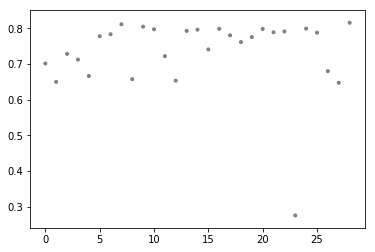

In [2]:
test.pop_show()

['gray', 'gray', 'gray', 'gray', 'gray', 'gray', 'gray', 'blue', 'gray', 'blue', 'gray', 'gray', 'gray', 'gray', 'gray', 'gray', 'gray', 'gray', 'gray', 'gray', 'gray', 'gray', 'gray', 'gray', 'gray', 'gray', 'gray', 'blue', 'red']


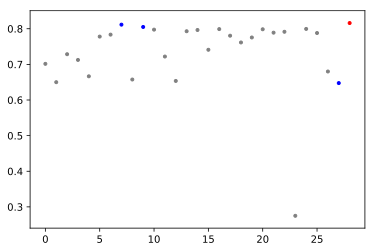

In [22]:
# def pop_show(self):
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
''' 画出种群变化分布图 '''
best_individual = test.population[0].dna_cnt
live_individual = []
for i in test.population:
    live_individual.append(i.dna_cnt)

global DNA_cnt
show_x = []
show_y = []
show_color = []
for i in range(DNA_cnt + 1):
    if i in test.fitness_dir:
        show_x.append(i)
        show_y.append(test.fitness_dir[i])
        if i in live_individual:
            if i == test.population[0].dna_cnt:
                show_color.append('red')
            else:
                show_color.append('blue')
        else:
            show_color.append('gray')


print(show_color)
plt.scatter(show_x, show_y, c=show_color, marker='.')
plt.show()

In [20]:
print (live_individual)
print (test.population[0].dna_cnt)
print (show_x)
print (show_y)
print (show_color)
print (DNA_cnt)


[28, 7, 9, 27, 29]
28
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]
[0.7015, 0.65, 0.7285, 0.7125, 0.6665, 0.778, 0.7835, 0.8115, 0.6575, 0.805, 0.7975, 0.722, 0.6535, 0.793, 0.7965, 0.741, 0.799, 0.7805, 0.7615, 0.7755, 0.7985, 0.789, 0.7915, 0.275, 0.7995, 0.788, 0.68, 0.6475, 0.816]
['gray', 'gray', 'gray', 'gray', 'gray', 'gray', 'gray', 'b', 'gray', 'b', 'gray', 'gray', 'gray', 'gray', 'gray', 'gray', 'gray', 'gray', 'gray', 'gray', 'gray', 'gray', 'gray', 'gray', 'gray', 'gray', 'gray', 'b', 'red']
30
